In [1]:
!which python

/home/li.shansho/capstone/brian/bin/python


In [2]:
!git clone https://github.com/BBQ591/NR-SLD-CNN.git

Cloning into 'NR-SLD-CNN'...
remote: Enumerating objects: 60, done.
remote: Counting objects: 100% (23/23), done.
remote: Compressing objects: 100% (16/16), done.
remote: Total 60 (delta 8), reused 19 (delta 7), pack-reused 37 (from 1)
Unpacking objects: 100% (60/60), done.


In [2]:
!cd NR-SLD-CNN

In [3]:
!pwd

/home/li.shansho/capstone/brian


In [4]:
pip install refl1d

Note: you may need to restart the kernel to use updated packages.


In [5]:
pip install seaborn

Note: you may need to restart the kernel to use updated packages.


In [6]:
pip install plotly

Note: you may need to restart the kernel to use updated packages.


In [7]:
pip install ipympl

Note: you may need to restart the kernel to use updated packages.


In [4]:
#importing python files

import sys
import os
import math
import json
import numpy as np

import refl1d
from refl1d.names import *

import pandas as pd
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
%matplotlib inline
import seaborn as sea

In [6]:
#This block is the class that is used to generate the SLD and NR curves

from scipy.interpolate import CubicSpline
import random
def calculate_reflectivity(q, model_description, q_resolution=0.0294855):
    """
        Reflectivity calculation using refl1d
    """
    zeros = np.zeros(len(q))
    dq = q_resolution * q / 2.355

    # The QProbe object represents the beam
    probe = QProbe(q, dq, data=(zeros, zeros))

    layers = model_description['layers']
    sample = Slab(material=SLD(name=layers[0]['name'],
                               rho=layers[0]['sld']), interface=layers[0]['roughness'])
    # Add each layer
    for l in layers[1:]:
        sample = sample | Slab(material=SLD(name=l['name'],
                               rho=l['sld'], irho=l['isld']),
                               thickness=l['thickness'], interface=l['roughness'])

    probe.background = Parameter(value=model_description['background'], name='background')
    expt = Experiment(probe=probe, sample=sample)

    q, r = expt.reflectivity()
    z, sld, _ = expt.smooth_profile()
    #this makes all SLD curves have 900 datapoints per curve
    zNew = np.linspace(z[0], z[-1], num=900)
    newCurve = CubicSpline(z, sld)
    sldNew = []
    for i in range(zNew.shape[0]):
      sldNew.append(newCurve(zNew[i]))
    return model_description['scale'] * r, zNew, sldNew
class ReflectivityModels(object):
        # Neutrons come in from the last item in the list

    def __init__(self,q=None, name='polymer'):

        self.parameters = [
                  # the naming order here is opposite to that in the experiment fitting.
                  # backing layer
                  dict(i=0, par='sld', bounds=[2.07, 2.07]),
                  dict(i=0, par='roughness', bounds=[1.177, 2.2227]),
            
                  # The following is the Si oxide layer
                  dict(i=1, par='sld', bounds=[3.47, 3.47]),
                  dict(i=1, par='thickness', bounds=[9.7216, 14.624]),
                  dict(i=1, par='roughness', bounds=[1.2176, 2.998]),

                  # The next layers are the polymer
                  dict(i=2, par='sld', bounds=[3.7235, 4.197]),
                  dict(i=2, par='thickness', bounds=[45.181,98.867]),
                  dict(i=2, par='roughness', bounds=[23.677,38.969]),
            
                  dict(i=3, par='sld', bounds=[1.6417, 2.7927]),
                  dict(i=3, par='thickness', bounds=[117.4,141.66]),
                  dict(i=3, par='roughness', bounds=[19.32,95.202]),
            
                  dict(i=4, par='sld', bounds=[3.2515, 4.6755]),
                  dict(i=4, par='thickness', bounds=[64.482,94.768]),
                  dict(i=4, par='roughness', bounds=[15.713,28.007]),
            
                  dict(i=5, par='sld', bounds=[3.5769, 4.9837]),
                  dict(i=5, par='thickness', bounds=[65.193,83.334]),
                  dict(i=5, par='roughness', bounds=[9.7741,25.373]),
            
                  dict(i=6, par='sld', bounds=[2.4606,4.4906]),
                  dict(i=6, par='thickness', bounds=[58.479, 86.738]),
                  dict(i=6, par='roughness', bounds=[66.519, 110.11]),
                 ]
        
        # 194438
        self.model_description = dict(layers=[
                    dict(thickness=0, sld=2.07, isld=0, roughness=1.5215, name='backing'),  # backing
                    dict(thickness=9.7216, sld=3.47, isld=0, roughness=1.2176, name='layer6'), 
                    dict(thickness=45.181, sld=4.0623, isld=0, roughness=23.677, name='layer5'), 
                    dict(thickness=140.04, sld=2.7927, isld=0, roughness=19.32, name='layer4'), 
                    dict(thickness=90.275, sld=3.2515, isld=0, roughness=19.672, name='layer3'),
                    dict(thickness=79.708, sld=3.5769, isld=0, roughness=14.606, name='layer2'),
                    dict(thickness=85.49, sld=2.4606, isld=0, roughness=67.927, name='layer1'),
                    dict(thickness=0, sld=0, isld=0, roughness=0, name='fronting'),  # fronting         
               ],
                 scale=0.98019,
                 background=1.9128e-06,
                        )
        # The following are unmodified physical parameters and corresponding reflectivity data
        self._pars_array = []
        self._refl_array = []
        # This creates the SLD curve list
        self._smooth_array = []
        # The following are the parameters, mapped between -1 and 1.
        self._train_pars = []
        self._train_data = None
        self._config_name = name

        if q is None:
            self.q = np.logspace(np.log10(0.008101436040354381), np.log10(0.1975709062238298), num=308)
        else:
            self.q = q

    @classmethod
    def from_dict(cls, pars, q_array=None):
        """
            Create ReflectivityModels object from a dict that
            defines the reflectivity model parameters and how
            the training set should be generated.
        """
        m = cls(q_array, name=pars['name'])
        m.model_description =  pars['model']
        m.parameters = pars['parameters']
        return m

    def generate(self, n=100):
        """
            Generate a random sample of models
        """
        npars = len(self.parameters)
        self._train_pars = np.random.uniform(low=-1, high=1, size=[n, npars])
        # Compute model parameters and reflectivity using these values
        self.compute_reflectivity()

    def to_model_parameters(self, pars):
        """
            Transform an array of parameters to a list of calculable models
        """
        pars_array = np.zeros(pars.shape)

        for i, par in enumerate(self.parameters):
            a = (par['bounds'][1]-par['bounds'][0])/2.
            b = (par['bounds'][1]+par['bounds'][0])/2.
            pars_array.T[i] = pars.T[i] * a + b

        return pars_array

    def compute_reflectivity(self):
        """
            Transform an array of parameters to a list of calculable models
            and compute reflectivity
        """
        print("Computing reflectivity")
        self._pars_array = self.to_model_parameters(self._train_pars)
        # Compute reflectivity
        for p in self._pars_array:
            _desc = self.get_model_description(p)
            r, z, sld = calculate_reflectivity(self.q, _desc)
            self._refl_array.append(r)
            self._smooth_array.append([z,sld])
    def get_model_description(self, pars):
        """
            Convert the parameter list to a model description that we can use
            to compute R(q).
        """
        for i, par in enumerate(self.parameters):
            self.model_description['layers'][par['i']][par['par']] = pars[i]
        return self.model_description

    def get_preprocessed_data(self, errors=None):
        """
            Pre-process data
            If errors is provided, a random error will be added, taking the errors array
            as a relative uncertainty.
        """
        if errors is None:

            self._train_data = np.log10(self._refl_array*self.q**2/self.q[0]**2)
        else:
            _data = self._refl_array * (1.0 + np.random.normal(size=len(errors)) * errors)
            # Catch the few cases where we generated a negative intensity and take
            # the absolute value
            _data[_data<0] = np.fabs(_data[_data<0])
            self._train_data = np.log10(_data*self.q**2/self.q[0]**2)

        return self._train_pars, self._train_data

    def save(self, output_dir=''):
        """
            Save all data relevant to a training set
            @param output_dir: directory used to store training sets
        """
        # Save q values
        np.save(os.path.join(output_dir, "%s_q_values" % self._config_name), self.q)

        # Save training set
        if self._train_data is not None:
            np.save(os.path.join(output_dir, "%s_data" % self._config_name), self._train_data)
            np.save(os.path.join(output_dir, "%s_pars" % self._config_name), self._train_pars)

    def load(self, data_dir=''):
        self.q = np.load(os.path.join(data_dir, "%s_q_values.npy" % self._config_name))
        self._train_data = np.load(os.path.join(data_dir, "%s_data.npy" % self._config_name))
        self._train_pars = np.load(os.path.join(data_dir, "%s_pars.npy" % self._config_name))
        return self.q, self._train_data, self._train_pars

In [7]:
m = ReflectivityModels()
#generate this many curves
m.generate(100000)
pars, train_data = m.get_preprocessed_data()
min_x = float('inf')
max_x = -float('inf')
for index in range(len(m._smooth_array)):
  min_x = min(m._smooth_array[index][0])
  for i in range(len(m._smooth_array[index][0])):
    m._smooth_array[index][0][i] -= min_x
#uncommenting the following will show plot the NR curves that are generated
# for index in range(len(m._refl_array)):
#     plt.plot(m._refl_array[index])
# plt.yscale("log")
# plt.show()

#saving values in npy files
settingUp = []
SLDSet = []
for i in range(len(m._smooth_array)):
  settingUp.append(np.array([m.q,m._refl_array[i]]))
  SLDSet.append(np.array(m._smooth_array[i]))

totalStack = np.stack(settingUp)
totalParams = np.stack(SLDSet)
print(totalStack.shape, totalParams.shape)
np.save("day2_SLD_CurvesPolySpecial.npy", totalParams)
np.save("day2_NR-SLD_CurvesPolySpecial.npy", totalStack)

Computing reflectivity
(100000, 2, 308) (100000, 2, 900)


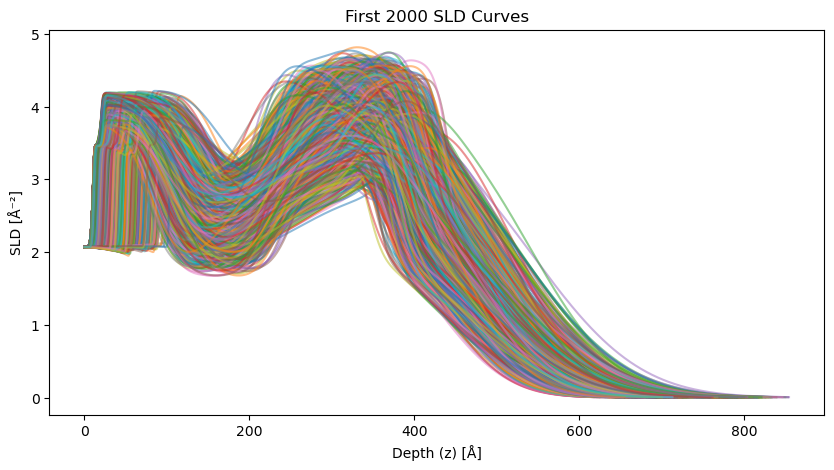

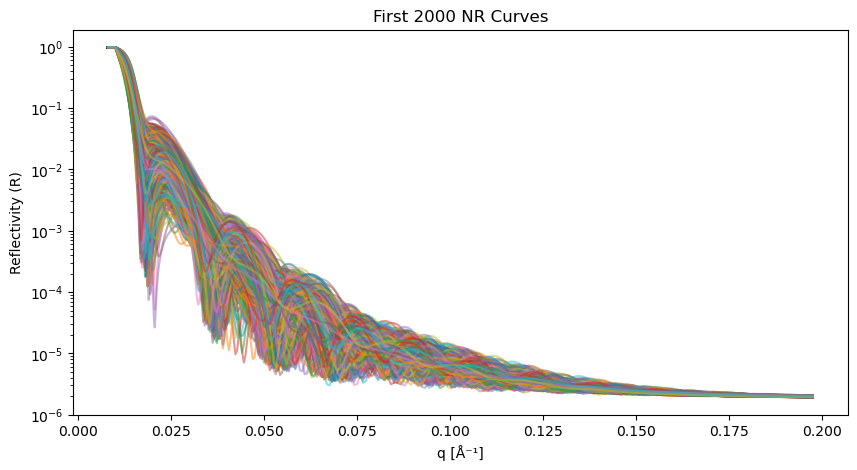

In [5]:
import numpy as np
import matplotlib.pyplot as plt

# load data
SLD_data = np.load("day2_SLD_CurvesPolySpecial.npy")  # (N, 2, M)
NR_SLD_data = np.load("day2_NR-SLD_CurvesPolySpecial.npy")  # (N, 2, K)

num_curves = min(2000, len(SLD_data)) 

# SLD curve
plt.figure(figsize=(10,5))
for i in range(num_curves): 
    plt.plot(SLD_data[i][0], SLD_data[i][1], alpha=0.5)  # x axis: depth z, y axis: SLD
plt.xlabel("Depth (z) [Å]")
plt.ylabel("SLD [Å⁻²]")
plt.title("First 2000 SLD Curves")
plt.show()

# NR curve
plt.figure(figsize=(10,5))
for i in range(num_curves): 
    plt.plot(NR_SLD_data[i][0], NR_SLD_data[i][1], alpha=0.5)  # x axis: q, y axis: R(q)
plt.xlabel("q [Å⁻¹]")
plt.ylabel("Reflectivity (R)")
plt.yscale("log")  
plt.title("First 2000 NR Curves")
plt.show()
